<a href="https://colab.research.google.com/github/arjunshenoymec/bitpredict/blob/main/BitPredict_forecast_using_classical_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting values of cyrpto-currency coins using ARIMA

In this notebook we perform the same task of forecasting values of cryptocurrency coins (specifically BitCoin) as in [Part1](https://github.com/arjunshenoymec/bitpredict/blob/main/notebooks/BitPredict-LSTM.ipynb) of our project. The difference here is that unlike the pervious notebook, we will use a classical statistics approach. Specifically, we will be using the ARIMA model for forecasting.  

In [1]:
# Setting up the environment and importing the necessary libraries. 

!pip3 install cpi
!pip3 install pmdarima
!pip3 install -U matplotlib

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import os
import cpi

/usr/local/lib/python3.7/dist-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


## Data Preparation

This section deals with the steps to obtain the data and prepare it for analysis and model training. These include: 
* Creating the DataFrame with Date as the index. 
* Changing the data to the appropriate type. 
* Adjusting the price values for inflation. 

In [2]:
# obtaining the data from the repo 
# Data originally obtained from https://www.kaggle.com/philmohun/cryptocurrency-financial-data
!wget https://raw.githubusercontent.com/arjunshenoymec/bitpredict/main/datasets/consolidated_coin_data.csv

--2022-04-04 12:23:29--  https://raw.githubusercontent.com/arjunshenoymec/bitpredict/main/datasets/consolidated_coin_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2274439 (2.2M) [text/plain]
Saving to: ‘consolidated_coin_data.csv.1’

consolidated_coin_d 100%[===================>]   2.17M  --.-KB/s    in 0.01s   

2022-04-04 12:23:29 (171 MB/s) - ‘consolidated_coin_data.csv.1’ saved [2274439/2274439]



In [3]:
df = pd.read_csv("consolidated_coin_data.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"])

# Converting the close values to floating point numbers, they are currently present as stirngs
df['Close'] = df['Close'].apply(lambda x: float(x.replace(",",""))) 


# logic to getting the data pertaining to a particular currency 
def filter_by_currency(df, currency):
  currency_df = df[df['Currency']==currency]
  currency_df = pd.DataFrame(currency_df['Close']).rename(columns={"Close": "price"})
  currency_df['year'] = currency_df.index.year
  return currency_df

In [4]:
# Filtering only bitcoin data
data = filter_by_currency(df, 'bitcoin')
# Reversing the order of entries in the dataframe since they are in 
# reverse chronological order. 
data = data.iloc[::-1]
data

,price,year
Date,,
2013-04-28,134.21,2013
2013-04-29,144.54,2013
2013-04-30,139.00,2013
2013-05-01,116.99,2013
2013-05-02,105.21,2013
...,...,...
2019-11-30,7569.63,2019
2019-12-01,7424.29,2019
2019-12-02,7321.99,2019


In [5]:
# Adjusting for inflation
data['inflated_price'] = data.apply(lambda x: cpi.inflate(x['price'],int(x['year'])), axis=1)

prices = data.inflated_price.to_numpy()
prices

array([ 156.1098559 ,  168.12546436,  161.68146911, ..., 7760.55273394,
       7758.60252409, 7686.40236371])

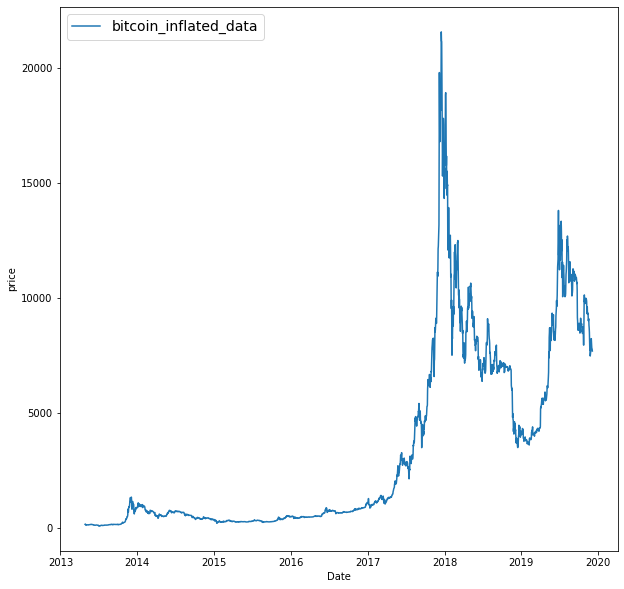

In [6]:
# Plotting the data 
plt.figure(figsize=(10, 10))
plt.plot(data.index.to_numpy(), data.inflated_price.to_numpy(), label="bitcoin_inflated_data")
plt.xlabel('Date')
plt.ylabel('price')
plt.legend(fontsize=14)
plt.show()

## Data Analysis

ARIMA (short for ‘Auto Regressive Integrated Moving Average’) is actually a class of models that ‘explains’ a given time series based on its own past values. The base assumption here is that the value of a quantity at time `t` can be predicted solely based on its past values (`t-1`, `t-2`, `t-3` and so on) commonly referred to as "lags" and the errors that were observed while trying to predict these past lags.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA.

ARIMA has 3 key parameters namely `p`, `d` and `q`.
* `p` is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. In a pure AR model the value of the quantity at time `t` can be predicted solely based on the lag values. 
\begin{align}
        \mathbf{y_t} = \alpha + \beta_1.{y_{t-1}} + \beta_2.{y_{t-2}} + \beta_3.{y_{t-3}} + ... + \beta_p.{y_{t-p}} + ϵ_t
    \end{align}
* `q` is the order of the 'moving average' (MA) term. In a purely MA model the value at time t is calculated by agregating the errors observed (the ϵ values in the equation above) while calculating the previous lags.

\begin{align}
        \mathbf{y_t} = \alpha + \phi_1.{ϵ_{t-1}} + \phi_2.{ϵ_{t-2}} + \phi_3.{ϵ_{t-3}} + ... + \phi_q.{ϵ_{t-q}} + ϵ_t
    \end{align}

* `d` is the number of differencing operations required to make the series "stationary" (ref: https://otexts.com/fpp2/stationarity.html#stationarity). 

The following sub-sections focus on finding the optimum value for these 3 parameters for this given time-series of bitcoin price values. 

### Determining the d value

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero quickly. (More about ACF plots can be read [here](https://tinyurl.com/yjk4f372)).

Before we move on to using ACF plots, we should test if the given series is already stationary. This can be done using a test known as the [Augmented Dickey-Fuller Test](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/) or the ADF test for short. 

In [7]:
# Step 1a. Checking if the series is already stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(prices)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.6612639215767895
p-value: 0.45117278287638657


p-value > 0.05 so the series as it is right now is not stationary, we need to determine the number of differencing operations (`d`) to perform on it. As a start let's try to plot the ACF for the current series and it's first difference

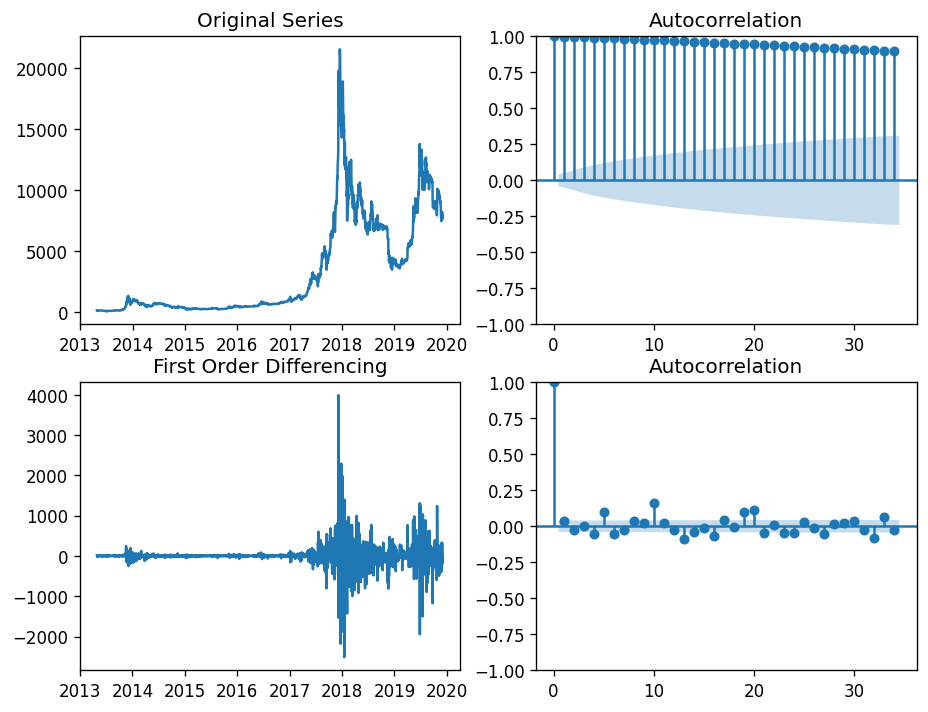

In [28]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(data.inflated_price)
axes[0, 0].set_title('Original Series')
plot_acf(data.inflated_price, ax=axes[0, 1])

axes[1, 0].plot(data.inflated_price.diff())
axes[1, 0].set_title('First Order Differencing')
plot_acf(data.inflated_price.diff().dropna(), ax=axes[1, 1])
plt.show()

In the above plots we can see that the ACF values when considering the series by itself do not reduce to zero immediately, it is a slow decline. While in the case of the first order difference values, the values tend to go to zero pretty quickly. 

The ACF values going to zero implies that the series passed to it is stationary (Ref: https://otexts.com/fpp2/stationarity.html#differencing). 

So in our case, the first order difference is stationary, meaning the minimum number of differencing operations is `1`. 

We can verify this using another library `pmdarima` which has a function that computes the minimum number of differencing operations needed. 

In [24]:
# source: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html
from pmdarima.arima.utils import ndiffs
# Determining the number of diffs to be performed 
print(ndiffs(prices, test='adf'))

1


In [9]:
# Verifying that the first order difference is stationary using the ADF test.
result_first_order = adfuller(data.inflated_price.diff().dropna())
print(f'ADF Statistic: {result_first_order[0]}')
print(format(float(result_first_order[1]), '.27f'))

ADF Statistic: -9.430816707019078
0.000000000000000519607596467


In [10]:
# Setting d to 1
d = 1

### Determining the p value

As mentioned before, `p` is the number of lags to be used in the AR part of the equation. We determine this by using the Partial-ACF (PACF) values. 

PACF signifies how strongly a given lag correlates to the current value after excluding the contributions from the other intermediate lags. Basically, it is the coeffient of the given lag in the AR equation. 

Going back to our AR equation

\begin{align}
        \mathbf{y_t} = \alpha + \beta_1.{y_{t-1}} + \beta_2.{y_{t-2}} + \beta_3.{y_{t-3}} + ... + \beta_p.{y_{t-p}} + ϵ_t
\end{align}

Here the PACF of lag 3 with respect to yt is the coefficient of 𝑦𝑡−3 (𝛽3). 


Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be the number of lags that crosses the significance limit in the PACF plot. 

So in our case, we plot the PACF values for the first order differencing and observe which lags cross the significance limt. 

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


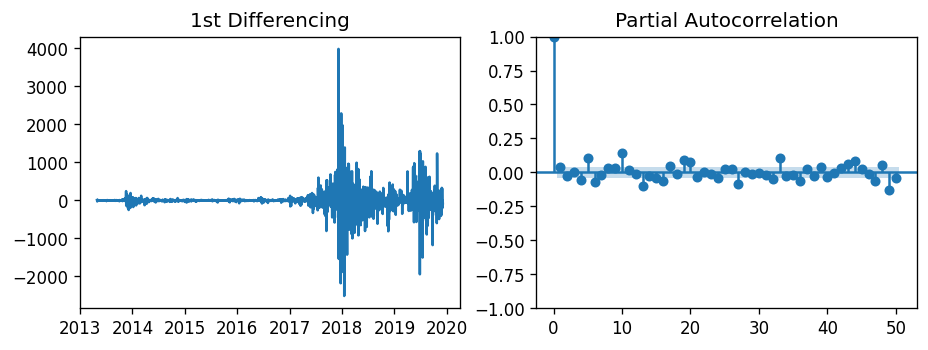

In [11]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)

axes[0].plot(data.inflated_price.diff().dropna())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.inflated_price.diff().dropna(), ax=axes[1], lags=50)
plt.show()

Here we see that the first lag itself crosses the significance limit by a large margin, we can ignore the others (smaller value for p and q, simplifiy the overall equation). 

In [12]:
# Setting p to 1
p = 1

### Determining the q value

Similar to the above section, we use the ACF plot of the first order difference series to determine `q`. An MA term is technically, the error of the lagged forecast. The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series. 

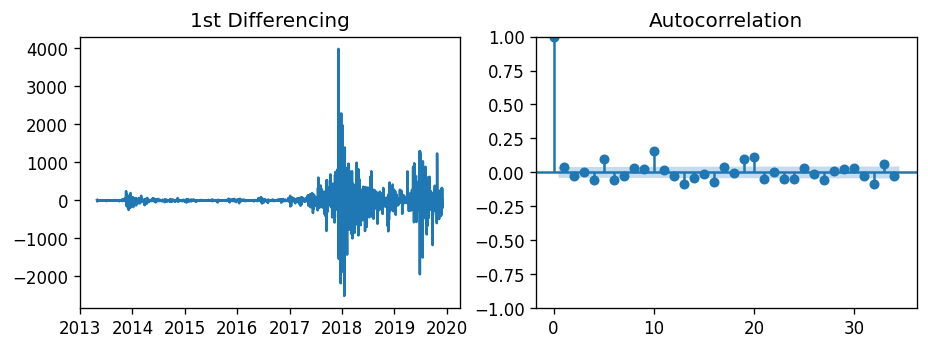

In [29]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2)
axes[0].plot(data.inflated_price.diff().dropna())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.inflated_price.diff().dropna(), ax=axes[1])
plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 1. Choose the smaller value to simplify the over all ARIMA equation.  

In [31]:
# Setting q to 1.
q=1

## Test Train split

Now that we've got values for the parameters to be passed to the ARIMA equation, lets prepare the data for training and prediction. 

The plan here is to train the model with one part of the entire timeseries (the training set), use the trained model to predict the future values and compare the predictions made with the actual values (the testing set). 

The test-train split in such cases is fairly straightforward, all we have to do is split the timeseries into two a training series and a testing series. The values in both the sets **should** be consecutive in the actual series to preserve the temporal relation between obervations. 

In other words we **cannot** just take values from random indices from the original series, we have to just literally take all the values up to a splitting point as the training set and the consider the remaining values from the splitting point as the testing set. 

In [30]:
prices

array([ 156.1098559 ,  168.12546436,  161.68146911, ..., 7760.55273394,
       7758.60252409, 7686.40236371])

In [16]:
split = 0.7
limit = int(len(prices)*split)
train_data, test_data = prices[:limit], prices[limit:]

## Training and prediction

In [34]:
history = [x for x in train_data]
model_predictions = []

for i in range(len(test_data)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    model_predictions.append(output[0])
    true_test_value = test_data[i]
    history.append(true_test_value)

## Evaluation

The first thing we do is plot the actual values along with the predicted values to observe how close they are. 

In [17]:
dates = data.index.to_numpy()

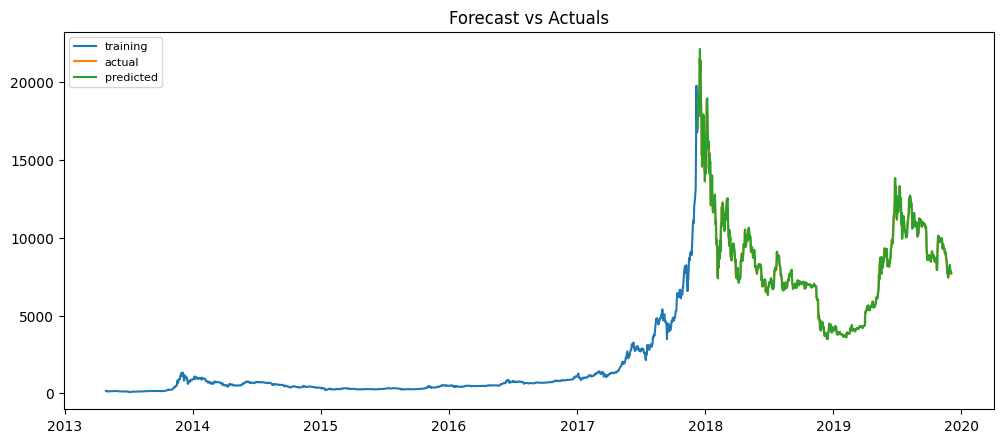

In [35]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(dates[:limit], train_data, label='training')
plt.plot(dates[limit:], test_data, label='actual')
plt.plot(dates[limit:], model_predictions, label='predicted')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The model seems to have predicted the values pretty accurately.  Now we can quantify the performance of the model by using the same performance indicators used in [part1](https://github.com/arjunshenoymec/bitpredict/blob/main/notebooks/BitPredict-LSTM.ipynb).  

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

In [37]:
mse = mean_squared_error(test_data, model_predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(test_data, model_predictions)
mape = mean_absolute_percentage_error(test_data, model_predictions)

{'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}

{'mae': 266.0068459655287,
 'mape': 0.028765267287518045,
 'mse': 200058.92920010877,
 'rmse': 447.2794754961475}

From these numbers, it seems that for this given timeseries of currency values a classic statiscal approach like ARIMA seems to be doing better than a deep learning using LSTMs and neural networks. 